# rCSI released by WFP (vam food security analysis)

Link to *Reduced Coping Strategy Index* data released by WFP: https://vam.wfp.org/mvam_monitoring/databank_csi.aspx

Link to *Shapefile* data released by OCHA (The Humanitarian Data Exchange): https://data.humdata.org/

In [1]:
from matplotlib.lines import Line2D
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
plt.style.use("ggplot")

In [2]:
# Coping Strategy Index (CSI) proxy indicator for food security analysis.
df = pd.read_excel("mVam_ReducedCopingStrategiesIndex.xlsx")
df.head()

,Country,Year,Month,AdminStrata,Mean,Median,Coping Prevalence,% Reducing Meals,% Restricting Consumption of Adults,% Receiving help from family friends,% Limiting Portion Size,% Using Less Expensive Food
0,Democratic Republic of the Congo,2019.0,September,Kasai-Central,25.48,24.0,98.92,88.89,75.99,68.46,89.61,80.64
1,Yemen,2019.0,September,Al Bayda,19.64,18.0,87.36,67.21,64.51,56.47,73.50,76.73
2,Yemen,2019.0,September,Al Mahwit,21.46,21.0,88.58,74.70,76.82,65.92,81.76,73.39
3,Yemen,2019.0,September,Dhamar,23.12,24.0,91.29,69.92,70.21,64.88,79.90,80.10
4,Yemen,2019.0,September,Ibb,21.49,21.0,91.44,69.60,69.54,69.18,75.21,82.38


ATTENTION: some items in the dataframe have NaN values in correspondence of temporal information, rCSI values and also AdminStrata information.

### Brief keys description

- *Country*: name of the country considered in the survey.
- *AdminStrata*: name of the provinces/regions of the country considered in the survey (or smaller granularity: districts, cities, camps, etc). 
- *Year, Month*: temporal information.
- *Mean, Median*: mean and median of the rCSI household values.
- *Coping Prevalence*: a percentage that sheds light on how the households have mobilized to cope with food shortages.
- *Reducing Meals, Restricting Consumption of Adults, Receiving help from family friends, Limiting Portion Size, Using Less Expensive Food*: a standard short list of five coping strategies.

### Preprocessing
#### Remove NaN values

In [3]:
# Show the sub-dataframe with NaN values.
nans = lambda df: df[df.isnull().any(axis = 1)]
print(nans(df).shape)
nans(df).head()

(366, 12)


,Country,Year,Month,AdminStrata,Mean,Median,Coping Prevalence,% Reducing Meals,% Restricting Consumption of Adults,% Receiving help from family friends,% Limiting Portion Size,% Using Less Expensive Food
61,Syria,2019.0,July,NaN,23.64,24.08,89.23,61.41,62.75,65.60,67.37,74.32
87,Syria,2019.0,June,NaN,18.66,16.33,86.41,59.49,51.24,62.90,52.29,76.13
106,Syria,2019.0,May,NaN,24.30,20.85,97.32,73.09,79.77,87.50,55.04,78.54
107,Syria,2019.0,May,NaN,18.68,14.83,80.28,47.06,39.45,58.13,40.83,66.44
122,Syria,2019.0,April,NaN,22.14,20.00,94.33,68.20,65.19,67.15,67.27,81.05


In [4]:
# Take into consideration the dataframe unless NaN values.
df = pd.concat([df, nans(df)]).drop_duplicates(keep = False)
print("The consistent data available for a time-series analysis are:", len(df))
df.head()

The consistent data available for a time-series analysis are: 2610


,Country,Year,Month,AdminStrata,Mean,Median,Coping Prevalence,% Reducing Meals,% Restricting Consumption of Adults,% Receiving help from family friends,% Limiting Portion Size,% Using Less Expensive Food
0,Democratic Republic of the Congo,2019.0,September,Kasai-Central,25.48,24.0,98.92,88.89,75.99,68.46,89.61,80.64
1,Yemen,2019.0,September,Al Bayda,19.64,18.0,87.36,67.21,64.51,56.47,73.50,76.73
2,Yemen,2019.0,September,Al Mahwit,21.46,21.0,88.58,74.70,76.82,65.92,81.76,73.39
3,Yemen,2019.0,September,Dhamar,23.12,24.0,91.29,69.92,70.21,64.88,79.90,80.10
4,Yemen,2019.0,September,Ibb,21.49,21.0,91.44,69.60,69.54,69.18,75.21,82.38


#### Other small fixes

Every country has an entry of the AdminStrata key equal to the self-name (Country key), I delete it. Moreover, the strings of AdminStrata key for Nigeria country are sometimes lowercase and sometimes uppercase, I change them to obtain uniform values (lowercase with first capital letter).

In [5]:
df = df[~df.AdminStrata.isin(df.Country.unique())]

In [6]:
def to_lower(country, admin):
    if country == "Nigeria":
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

#### Creation of an accurate datetime feature

Creation of a datetime column merging the available time values (Year and Month keys) into one column (creating a deafult day (the end of the month) column to allow the use of pd.to_datetime command). I take a step back and I add the missing datetime values for every AdminStrata key of every country in order to show the real timeseries graphs (based on the own max and min datetime values).

In [7]:
data = pd.to_datetime(df["Year"].astype(int).astype(str) + df["Month"], format = "%Y%B") # Combine hour and date to datetime.
df.insert(1, "Datetime", data)
df.drop(["Year", "Month"], axis = 1, inplace = True) # Drop duplicate infomation.
df.sort_values("Datetime", ascending = True, inplace = True) # Sort on datetime.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("M").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,Mean,Median,Coping Prevalence,% Reducing Meals,% Restricting Consumption of Adults,% Receiving help from family friends,% Limiting Portion Size,% Using Less Expensive Food
0,Democratic Republic of the Congo,Kalunga,2017-05-31,11.63,10.0,93.9,62.68,20.73,45.85,53.17,90.24
1,Democratic Republic of the Congo,Kalunga,2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Democratic Republic of the Congo,Kalunga,2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Democratic Republic of the Congo,Kalunga,2017-08-31,21.75,21.0,100.0,96.77,23.50,53.92,99.08,100.00
4,Democratic Republic of the Congo,Kalunga,2017-09-30,20.30,20.0,100.0,100.00,16.67,50.00,100.00,100.00


## Analysis of the dataset

### Country key

In [8]:
#print(df.Country.describe())
print("The countries considered in the survey are", len(df.Country.unique()), ":", ", ".join(df.Country.unique()))

The countries considered in the survey are 15 : Democratic Republic of the Congo, Guinea, Iraq, Lesotho, Liberia, Madagascar, Malawi, Mozambique, Nigeria, Sierra Leone, Swaziland, Syria, Yemen, Zambia, Zimbabwe


### AdminStrata key

- **Guinea**: Guinea is divided into eight administrative regions: Boke, Conakry, Faranah, Kankan, Kindia, Labe, Mamou, N'Zerekore. The rCSI dataframe has the values of all the provinces and three additional regions: upper, middle and lower. The shapefile for Guinea is available with regions granularity (Administrative Boundaries Level 1 for the OCHA dataset) with all the 8 provinces.

- **Yemen**: The administrative division of Yemen is divided into two main divisions (governorates and districts). There are 22 governorates, including the capital Sana'a (Amanat Al Asima) and Socotra Archipelago. The rCSI dataframe has the values of 21 of these provinces (Socotra Archipelago is not included). The shapefile for Zambia is available with governorates granularity (Administrative Boundaries Level 1 for the OCHA dataset) with all 22 provinces.

- **Zambia**: Zambia is divided into 10 provinces for administrative purposes (Central, Copperbelt, Eastern, Luapula, Lusaka, Muchinga, North Western, Northern, Southern, Western). The rCSI dataframe has the values of 5 of these provinces (Copperbelt, Eastern, Lusaka, Southern, Western). The shapefile for Zambia is available with provincial granularity (Administrative Boundaries Level 1 for the OCHA dataset) with all 10 provinces.

- **Swaziland** (and also known as Eswatini): Eswatini is divided into four regions: Hhohho, Lubombo, Manzini, and Shiselweni. The rCSI dataframe has the values of all 4 regions. 

- **Democratic Republic of the Congo** (or DR Congo): DR Congo has 26 major provinces (Kinshasa, Ituri Province, Kongo Central, Haut-Uele, Kwango, Tshopo, Kwilu Province, Bas-Uele, Mai-Ndombe Province, Nord-Ubangi, Kasaï Province, Mongala, Kasaï-Central, Sud-Ubangi, Kasaï-Oriental, Équateur, Lomami Province, Tshuapa, Sankuru, Tanganyika Province, Maniema, Haut-Lomami, South Kivu, Lualaba Province, North Kivu, Haut-Katanga Province). The AdminStrata items of the rCSI dataframe follows this structure:

    - Kalunga: it is a populated place. ***ITEM TO VERIFY***
    - Kasai: Kasai Province is one of the 26 provinces of the Democratic Republic of the Congo.
    - Kasai-Central: Kasai Central is one of the 26 provinces of the Democratic Republic of the Congo.

- **Iraq**: Iraq is composed of nineteen governorates (or provinces). The governorates are subdivided into districts, which are further divided into sub-districts. The rCSI dataframe manages all the 19 governorates (in some cases, the governorates are studied in couple).

- **Liberia**: Liberia is divided into fifteen counties, which, in turn, are subdivided into a total of 90 districts and further subdivided into clans. The rCSI dataframe manages some of the 15 counties (in some cases, the governorates are studied in couple). ***THERE ARE TWO ITEMS ('Southeast w/o Bassa', 'Western') TO VERIFY***

- **Lesotho**: The AdminStrata items of the rCSI dataframe represents all the ten districts of Lesotho. In some case, some AdminStrata items are kept in couple or more. 

- **Madagascar**: Madagascar is divided into 22 regions. The rCSI dataframe has the values of 5 of these provinces (Analamanga, Analanjirofo, Androy, Anosy, Atsinanana).

- **Malawi**: Malawi is divided into 28 districts within three regions. The AdminStrata items of the rCSI dataframe represents all the districts of Malawi. In some case, some AdminStrata items are kept in couple or more.

- **Mozambique**: Mozambique is divided into ten provinces. The rCSI dataframe has the values of 4 of these provinces (Gaza, Inhambane, Manica, Tete).

- **Nigeria**: Nigeria is divided into 36 states. The AdminStrata items of the rCSI dataframe cover 3 states (Adamawa, Borno and Yobe) and each of these state is diveded into three parts: North, South, Central.

- **Sierra Leone**: The provinces of Sierra Leone are divided into 16 districts. The AdminStrata items of the rCSI dataframe represents 14 districts of Lesotho (Falaba and Karene not included) and they are are kept in couple or more. 

- **Syria**: The AdminStrata key of the rCSI dataframe contains a mix of cities, camps, districts, sub-districts and provinces. ***ALL ITEMS TO VERIFY*** 

- **Zimbabwe**: The Republic of Zimbabwe is broken down into 10 administrative Provinces, which are divided into 59 Districts and 1200 Wards. The rCSI dataframe manages all the 10 provinces and also additional geographical items (for example 'Midlands North' is not a province, the province is 'Midlands') and the item 'Lake Kariba'.


**N.B. For some countries (Guinea, Yemen, Zambia) is possible to represent rCSI values using the shapefiles by way of example.**

### Graphs of the metric (Coping Prevalence key) for every countries and governatores (AdminStrata key)

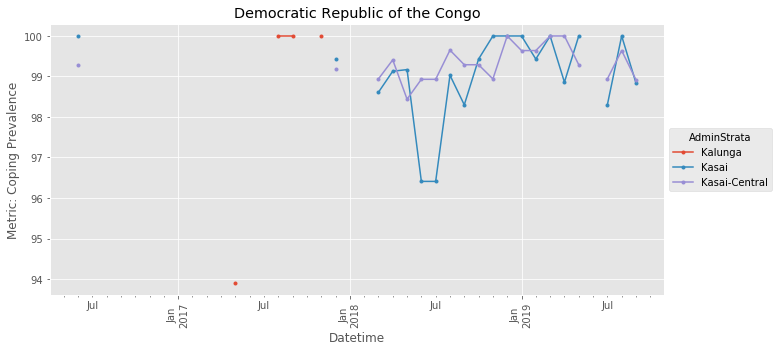

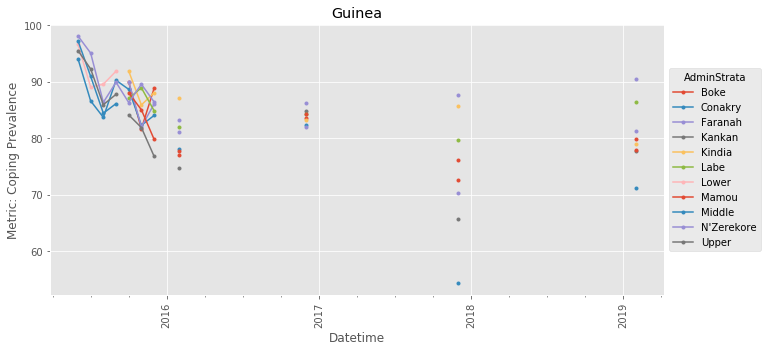

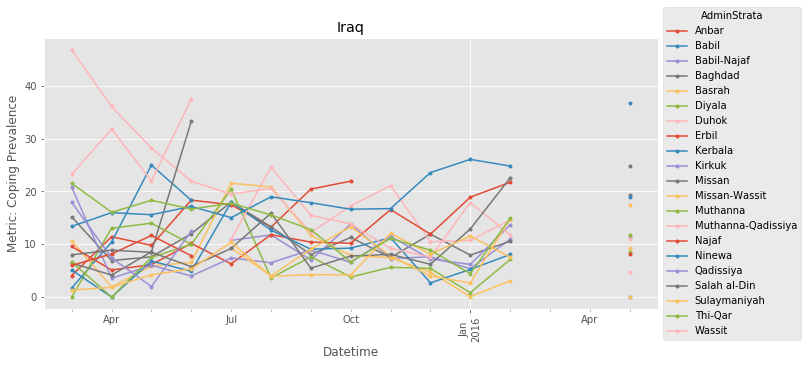

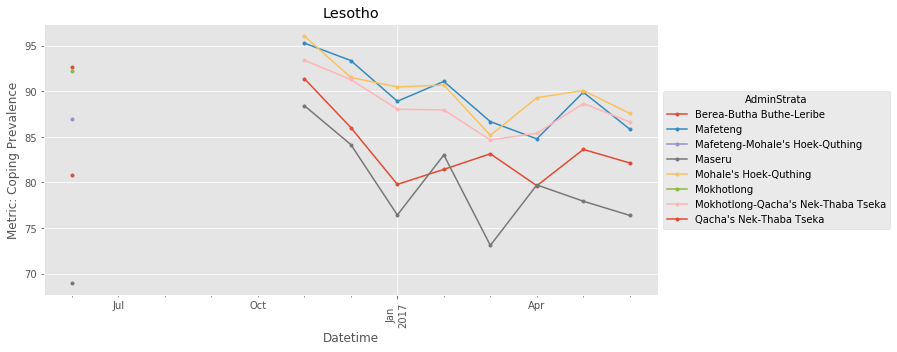

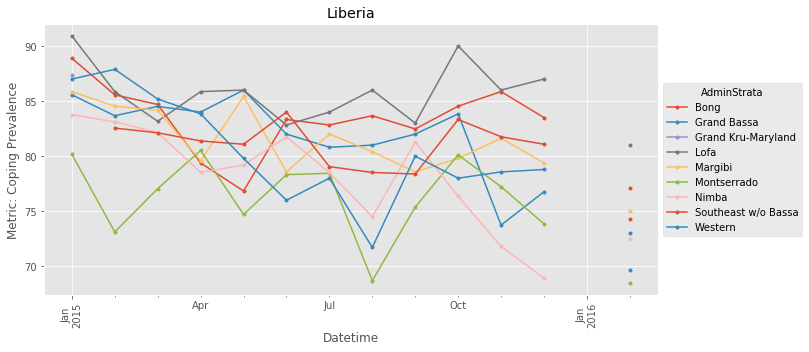

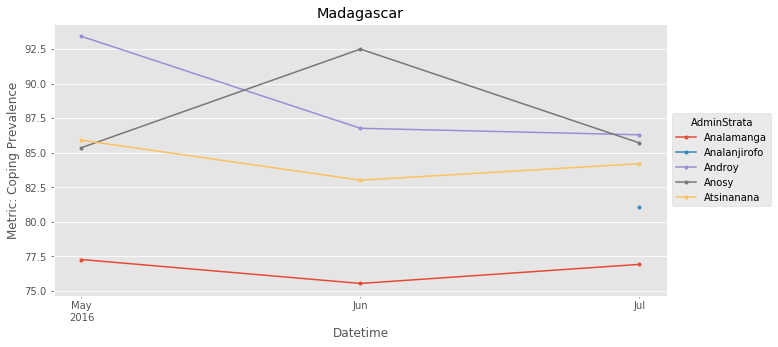

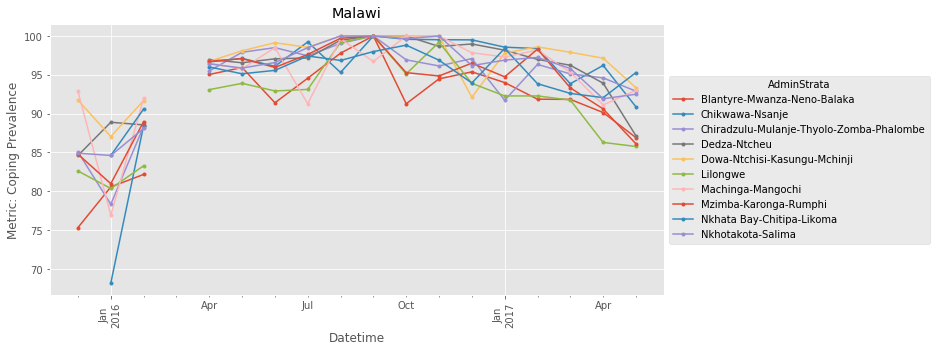

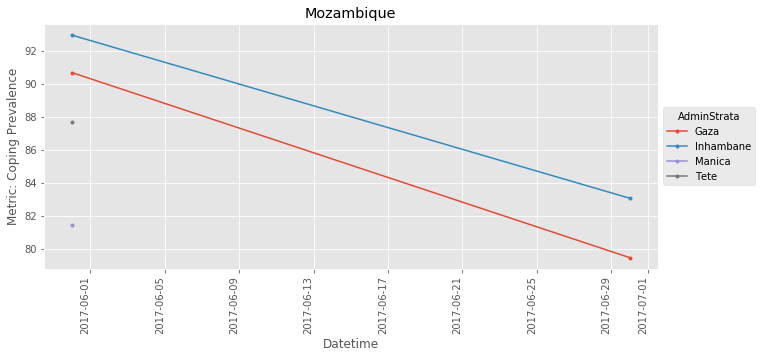

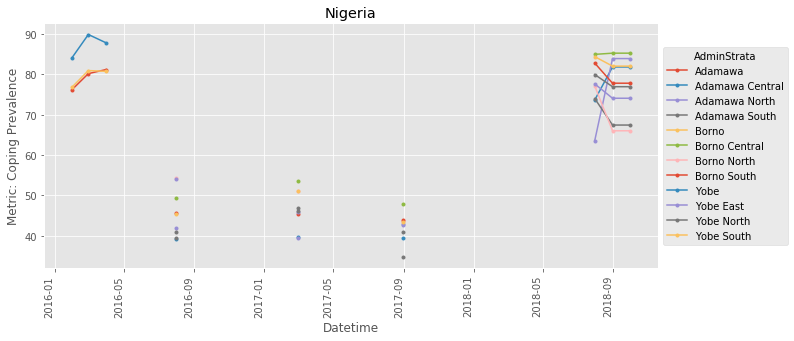

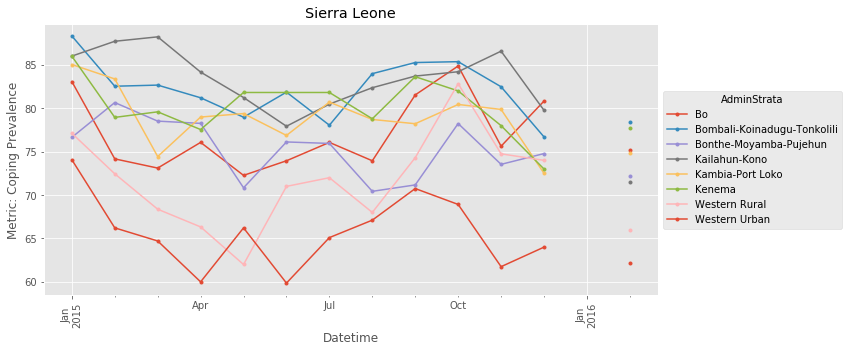

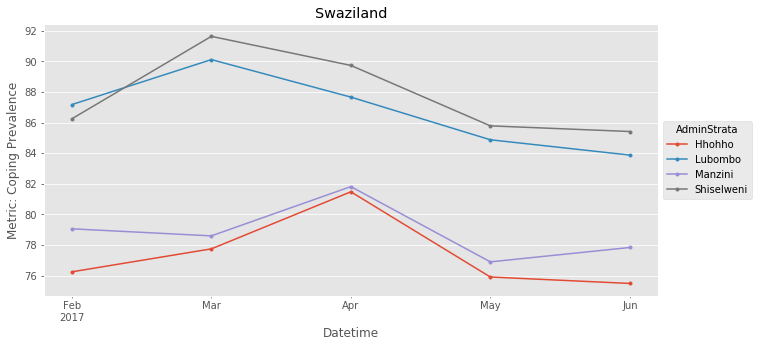

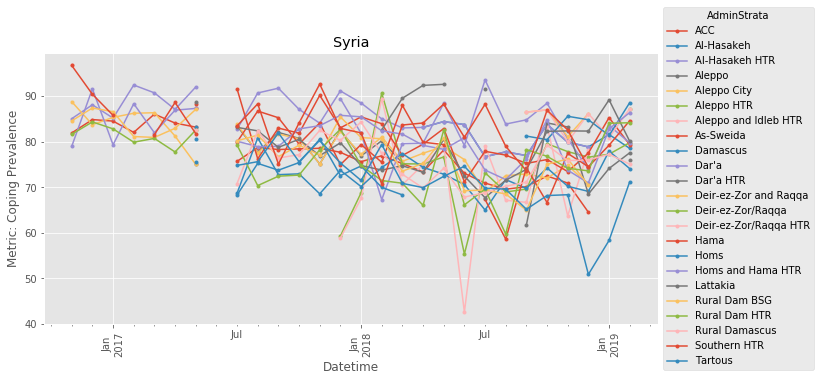

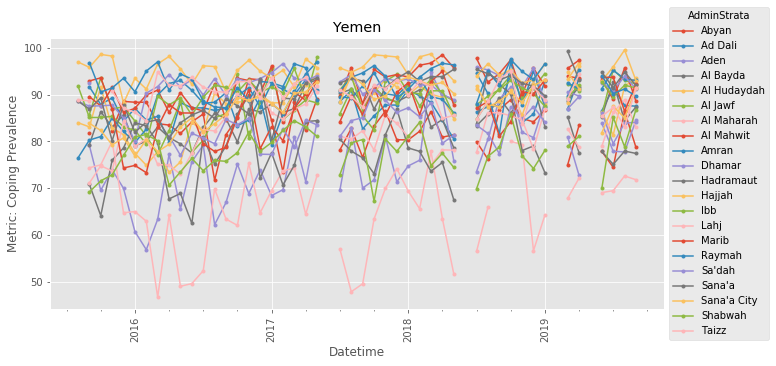

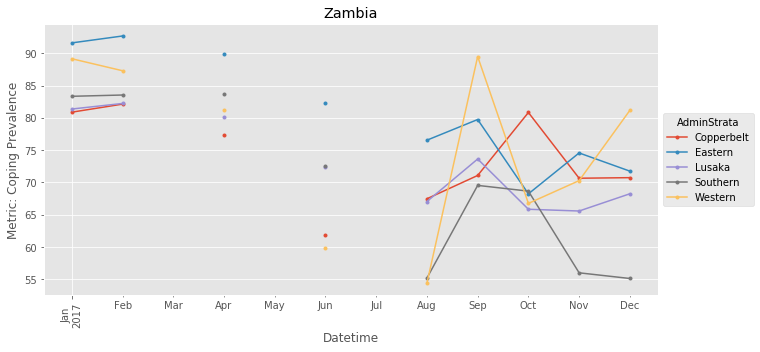

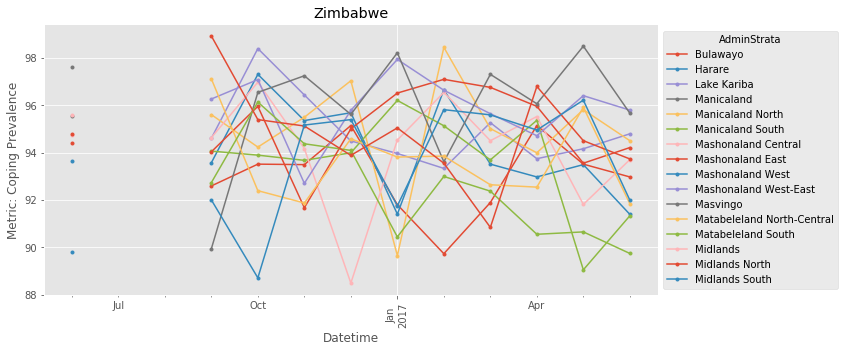

In [9]:
for country in df.Country.unique():
    sub_df = df[df.Country == country]
    f = plt.figure(figsize = (11, 5))
    plt.title(country, color = "black")
    sub_df.groupby(["Datetime", "AdminStrata"]).mean()["Coping Prevalence"].unstack().plot(ax = f.gca(), style = ".-")
    plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Coping Prevalence")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

### Shapefile representation

In [10]:
dict_shapefiles = {"Zambia": "zmb_popa_adm1_census2010f_ISCGM_CSO_OCHA_.shp",
                   "Yemen": "yem_admbnda_adm1_govyem_cso_20191002.shp",
                   "Guinea": "gin_admbnda_adm1_ocha_itos.shp"}

In [11]:
# Some AdminStrata keys don't fit between the rCSI dataframe and the dataframe of shapefiles.
# I change the items of the dataframe shaoefile to fit with the items of rCSI dataframe.
replacing_words = {"Yemen": [{"Ma'rib": "Marib", "Ta'iz": "Taizz", "Al Hodeidah": "Al Hudaydah", "Hadramawt": "Hadramaut", "Ad Dali'": "Ad Dali"}, {"ADM1_EN": "AdminStrata"}],
                   "Guinea": [{"Nzerekore": "N'Zerekore"}, {"admin1Name": "AdminStrata"}],
                   "Zambia": [None, {"PROVINCE": "AdminStrata"}]}

#### Example:

In [12]:
Country = "Yemen" # Yemen, Zambia or Guinea.
Month = 12
Year = 2016

In [13]:
shp_path = "./shape_files/" + Country + "_shapefile/" + dict_shapefiles[Country]
# Open the shapefile.
country = gpd.read_file(shp_path)

In [14]:
country.rename(columns = replacing_words[Country][1], inplace = True)
if replacing_words[Country][0] != None:
    country.replace(replacing_words[Country][0], inplace = True)

In [15]:
df_plot = df[(df.Datetime.dt.month  == Month) & (df.Datetime.dt.year  == Year) & (df.Country == Country)]
df_plot.head()

,Country,AdminStrata,Datetime,Mean,Median,Coping Prevalence,% Reducing Meals,% Restricting Consumption of Adults,% Receiving help from family friends,% Limiting Portion Size,% Using Less Expensive Food
1879,Yemen,Abyan,2016-12-31,20.12,18.93,93.14,68.84,66.06,50.59,80.20,67.62
1928,Yemen,Ad Dali,2016-12-31,17.94,15.90,87.35,48.07,46.71,44.61,69.78,71.63
1977,Yemen,Aden,2016-12-31,13.70,10.00,73.92,42.27,37.51,33.05,57.00,66.83
2026,Yemen,Al Bayda,2016-12-31,21.52,19.20,86.29,59.40,64.35,52.36,80.24,69.68
2076,Yemen,Al Hudaydah,2016-12-31,20.96,21.09,90.02,63.95,56.83,53.21,76.95,76.86


In [16]:
# Create a default NaN dataframe if no any data exist for the selected period.
empty = False
if df_plot.empty:
    df_plot = pd.DataFrame(np.nan, index = np.arange(len(df[df.Country == Country].AdminStrata.unique())), columns = df.columns)
    df_plot["AdminStrata"] = df[df.Country == Country].AdminStrata.unique()
    empty = True

In [17]:
# I add the relative metric column to the geopandas dataframe.
country = pd.merge(country, df_plot[["AdminStrata", "Coping Prevalence"]], on = ["AdminStrata"], how = "left") 

Text(0.5, 1, 'Yemen metric: Coping Prevalence')

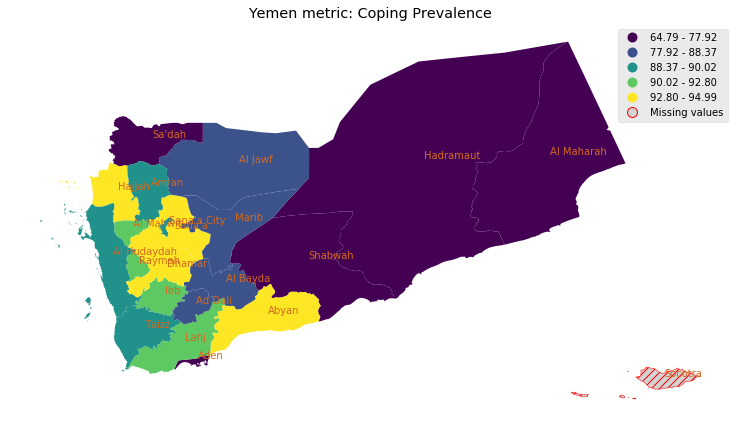

In [18]:
f, ax = plt.subplots(1, figsize = (13, 10))
if not empty:
    ax = country.plot(column = "Coping Prevalence", ax = ax, legend = True, scheme = "quantiles", missing_kwds = {"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
else:
    ax = country.plot(ax = ax, color = "lightgrey", edgecolor = "red", hatch = "///")
    legend_elements = [Line2D([0], [0], marker = "o", linestyle = "none", color = "red", label = "Missing values", markerfacecolor = "lightgrey", markersize = 10)]
    ax.legend(handles = legend_elements, loc = 'upper right')
for x, y, label in zip(country.centroid.x, country.centroid.y, country.AdminStrata):
    ax.annotate(label, xy = (x, y), xytext = (3, 3), textcoords = "offset points", color = "chocolate")
plt.axis("off")
plt.title(Country + " metric: Coping Prevalence")